In [31]:
import damask
import numpy as np
import matplotlib.pyplot as plt
import glob
import concurrent.futures
import csv
import time

Adding phase information into exported .vti files

In [2]:
v = damask.VTK.load('materials/DP1000_DB_new/DP.vti')
material_ID=v.get('material').flatten()
ma=damask.ConfigMaterial.load('materials/DP1000_DB_new/material.yaml')
phases = list(ma['phase'].keys())
info = []

for m in ma['material']:
    c = m['constituents'][0]
    phase = c['phase']
    info.append({'phase':   phase,
                 'phaseID': phases.index(phase),
                 'lattice': ma['phase'][phase]['lattice'],
                 'O':       c['O'],
                })
p   = np.array([d['phase'] for d in info])
pid = np.array([d['phaseID'] for d in info])

In [25]:
filelist = glob.glob('simulations/DP1000_3_cyclic_tension_load/*inc*.vti')

In [26]:
filelist

['simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc000.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc012.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc024.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc036.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc048.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc061.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc073.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc086.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc098.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc110.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc122.vti',
 'simulations/DP1000_3_cyclic_tension_load\\DP_cyclic_tension_lowres_inc137.vti',
 'simulations/DP

In [27]:
def add_phaseID(filename):
    print(f"Adding phase id to {filename}")
    v = damask.VTK.load(filename)
    v = v.set('phase',p[material_ID],'phase')
    v = v.set('phaseID',pid[material_ID],'phaseID')
    v.save(filename)
    print(f"Finished {filename}")
    return None

In [28]:
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    r = executor.map(add_phaseID, filelist)

Adding phase id to simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc000.vtiAdding phase id to simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc012.vti

Adding phase id to simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc024.vti
Adding phase id to simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc036.vti
Adding phase id to simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc048.vti
Adding phase id to simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc061.vti
Adding phase id to simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc073.vti
Adding phase id to simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc086.vti
Finished simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc048.vti
Adding phase id to simulations/DP1000_3_cyclic_tension_load\DP_cyclic_tension_lowres_inc098.vti
Finished simulations/DP1000_3_cyclic_tension_load\

Comparing DP1000 simulation to experiment

In [2]:
r = damask.Result('simulations/DP1000_3_linear_load_experiment/DP_linear_load_experiment.hdf5')

In [22]:
phases = r.phases
N = 1e6
x_data = [[] for _ in phases]
x_data.append([])
y_data = [[] for _ in phases]
y_data.append([])
for i in [int(_[10:]) for _ in r.increments]:
    print(f"Processing increment {i}")
    data=r.view(increments=i).get(['P', 'F'], flatten=False)
    index='increment_'+str(i)
    x_global = []
    y_global = []
    for j in range(len(phases)):
        temp = data[index]['phase'][phases[j]]['mechanical']['F'][:,0,0]
        x_global+= list(temp)
        x_data[j].append(np.average(temp))
        temp = data[index]['phase'][phases[j]]['mechanical']['P'][:,0,0]
        y_global+= list(temp)
        y_data[j].append(np.average(temp))
    x_data[-1].append(np.average(x_global))
    y_data[-1].append(np.average(y_global))

Processing increment 0
Processing increment 3
Processing increment 6
Processing increment 9
Processing increment 12
Processing increment 15
Processing increment 18
Processing increment 21
Processing increment 24
Processing increment 27
Processing increment 30
Processing increment 33
Processing increment 36
Processing increment 39
Processing increment 42
Processing increment 45
Processing increment 48
Processing increment 51
Processing increment 54
Processing increment 57
Processing increment 60
Processing increment 63
Processing increment 66
Processing increment 71
Processing increment 74
Processing increment 77
Processing increment 80
Processing increment 83
Processing increment 86
Processing increment 89
Processing increment 92
Processing increment 95
Processing increment 98
Processing increment 101
Processing increment 104
Processing increment 107
Processing increment 110
Processing increment 113
Processing increment 116
Processing increment 119
Processing increment 122
Processing i

In [12]:
stress = []
strain = []
time = []
with open('linear_stress_strain_1.csv') as file:
    rd = csv.reader(file, delimiter=',')
    next(rd); print(next(rd)); next(rd)
    for row in rd:
        time.append(float(row[0]))
        strain.append(float(row[1]))
        stress.append(float(row[2]))

['Test time', 'Strain', 'Stress']


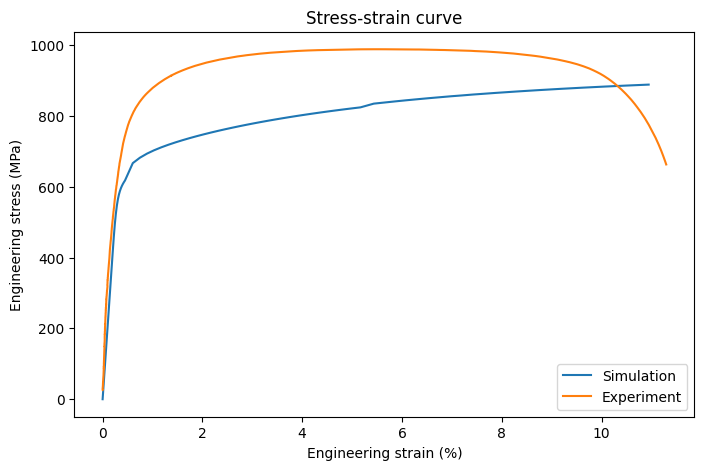

In [23]:
plt.figure(figsize=(8, 5))
plt.plot([(_-1)*100 for _ in x_data[-1]], [_/1e6 for _ in y_data[-1]], label="Simulation")
plt.plot(strain, stress, label="Experiment")
plt.xlabel('Engineering strain (%)')
plt.ylabel('Engineering stress (MPa)')
plt.title('Stress-strain curve')
plt.legend()
plt.show()

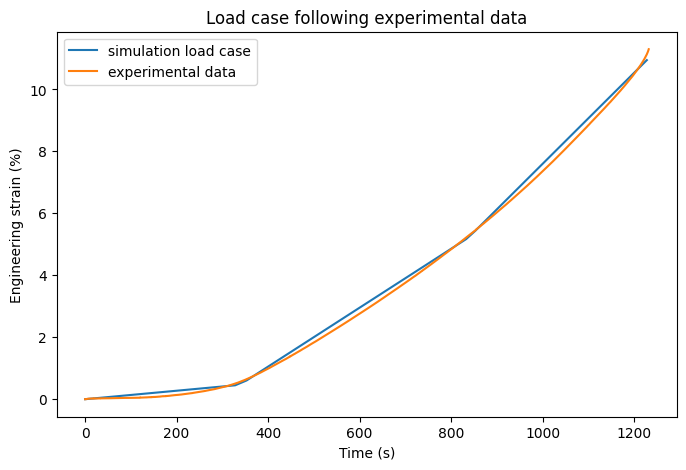

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(r.times, [(_-1)*100 for _ in x_data[-1]], label="simulation load case")
plt.plot(time, strain, label="experimental data")
plt.xlabel('Time (s)')
plt.ylabel('Engineering strain (%)')
plt.title('Load case following experimental data')
plt.legend()
plt.show()

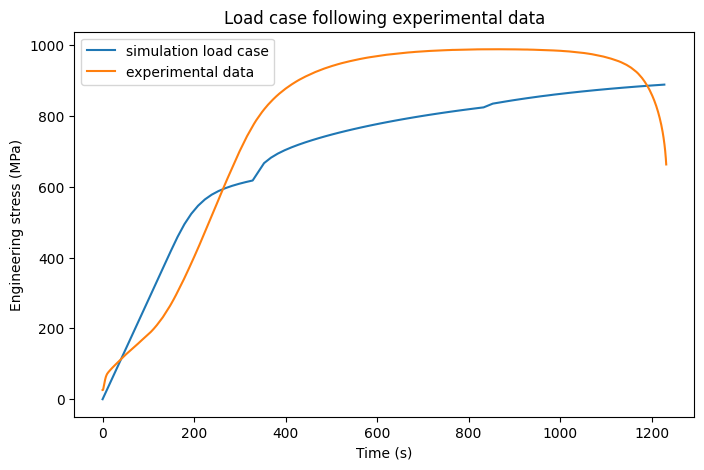

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(r.times, [(_)*1e-6 for _ in y_data[-1]], label="simulation load case")
plt.plot(time, stress, label="experimental data")
plt.xlabel('Time (s)')
plt.ylabel('Engineering stress (MPa)')
plt.title('Load case following experimental data')
plt.legend()
plt.show()